# Simulating Continuous-Time Systems

We'll start by just importing some things we'll need later.

In [1]:
%matplotlib inline
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

## Simple System

Consider the simple second-order system corresponding to a mass on a linear spring and damper:

$$
\ddot{x} + \frac{b}{m} \dot{x} + \frac{k}{m} x = 0
$$

We need to convert this to a system of first-order differential equations. That is, we need a set of equations where we have the first derivative of a variable on the left hand side, and everything on the right hand side is a function only of those variables on the left hand side -- no derivatives. These variables will be called state variables. Let $x_1 = x$ and $x_2 = \dot{x}$. Now, notice that:

$$\dot{x}_1 = \dot{x} = x_2$$

$$
\begin{eqnarray}
\dot{x}_2 &=& \ddot{x}\\
          &=& -\frac{b}{m} \dot{x} - \frac{k}{m} x\\
          &=& -\frac{b}{m} x_2 - \frac{k}{m} x_1
\end{eqnarray}
$$

In [2]:
def msd_eqns(x, t, m, b, k):
    # unpack the variables to make the equations clearer
    x1, x2 = x
    
    # first derivative of x1
    d_x1 = x2
    # first derivative of x2
    d_x2 = -(b/m)*x2 - (k/m)*x1
    
    # return deriviatives of the state variables
    return d_x1, d_x2

Actually simulate the system.

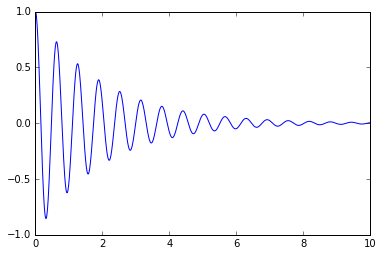

In [3]:
# initial conditions -- we'll set an initial position (x1)
xi = [1, 0]
t = np.linspace(0, 10, 1000)
x = odeint(msd_eqns, xi, t, args=(1, 1, 100))

plt.plot(t, x[:, 0])

## Higher-Order System

Here, we'll see how to simulate a more complicated example, which is the second simulation from the paper. The governing differential equations are:

$$
\ddot{x} + \left( \mu_0 - \mu \right) \dot{x} + \lambda \dot{x}^3 + \omega^2 x = 0
$$

$$
\dot{\mu} = \frac{1}{1 + x^2 + (\dot{x}/\omega)^2} - \mu + \frac{1}{2}
$$


Similarly to the mass-spring-damper system, we'll define variables $x_1$ and $x_2$ to rewrite these equations as state equations.

$$\dot{x}_1 = \dot{x} = x_2$$

$$
\begin{eqnarray}
\dot{x}_2 &=& \ddot{x}\\
          &=& -\left( \mu_0 - \mu \right) \dot{x} - \lambda \dot{x}^3 - \omega^2 x\\
          &=& -\left( \mu_0 - \mu \right) x_2 - \lambda x_2^3 - \omega^2 x_1
\end{eqnarray}
$$

$$
\dot{\mu} = \frac{1}{1 + x_1^2 + (x_2/\omega)^2} - \mu - \frac{1}{2}
$$

Let's write a function that takes in the current state variables (in a vector), the current time, and some parameters needed.

In [4]:
def oscillator_eqns(x, t, mu0, lam, om):
    # unpack the variables to make the equations clearer
    x1, x2, mu = x
    
    # first derivative of x1
    d_x1 = x2
    # first derivative of x2
    d_x2 = -(mu0 - mu)*x2 - lam*x2**3 - om**2*x1
    # first derivative of mu
    d_mu = 1/(1 + x1**2 + (x2/om)**2) - mu + 0.5
    
    # return deriviatives of the state variables
    return d_x1, d_x2, d_mu

And let's simulate it.

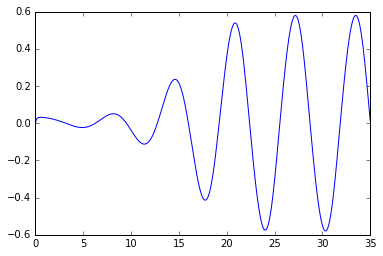

In [5]:
# give the system an initial velocity and intentionally mis-tune it
xi = [0, 0.3, -9]
t = np.linspace(0, 35, 1000)
x = odeint(oscillator_eqns, xi, t, args=(1, 1, 1))

plt.plot(t, x[:, 0])

## Impulsive Input

When we have impulsive inputs, the simulation method we've been using doesn't work so well. The function `odeint` actually doesn't obey the time array we pass to it (it uses an algorithm to determine how small to make the time step, and parameters for this algorithm are optional arguments for `odeint`). So if you have an input at $t = t_{\text{imp}}$, you can't rely on the time value passed to your equations function to determine if the input should happen now. However, even if you used a fixed time-step integration technique, the impulsive input will be problematic. Underlyingly, this is because a true impulse in continuous time is unrealizable. It's effect is to instantaneously bring the system to a certain condition. So if we are simulating by specifying the first derivative, there's no way for us to set the first derivative such that the system will be at the correct state at the next time step.

What we do instead is simulate the un-forced response of the system between the impulses. In the case of the first simulation from the paper, this is pretty easy because the input is periodic. At an input time step, we set the initial conditions of the system as they were before the input plus the effect of the impulse, then run the simulation until the next input comes along.

The equations for this system are already first-order equations, and we're going to ignore the input $u(t)$:

$$
\dot{x} = -\mu_0 x + \mu x
$$

$$
\dot{\mu} = \varepsilon \left( -a x - b \mu + c \right)
$$

Here's the function implementing these equations.

In [6]:
def integrator_eqns(x, t, mu0, eps, a, b, c):
    # unpack the variables to make the equations clearer
    x1, mu = x
    
    # first derivative of x1
    d_x1 = (mu - mu0)*x1
    # first derivative of mu
    d_mu = eps * (-a*x1 - b*mu + c)
    
    # return deriviatives of the state variables
    return d_x1, d_mu

The input will come in at every second, alternating between setting $x$ to 20 and 60 (starting at $t = 0$ by setting the initial state to 20). We'll make this input period a variable, so our simulation works more generally (in case we want to try it with 2 seconds between inuts, for example). Since the $x$ state is going to be set directly at the beginning of each simulation stage but $\mu$ is not, we keep the value of $\mu$ from the end of the previous stage and set it as the initial condition for the next stage. Here's the implementation.

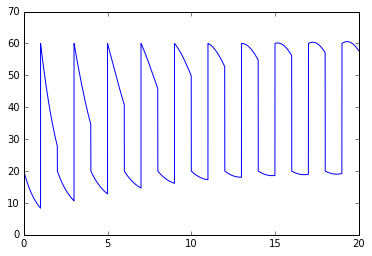

In [7]:
T = 20
T_input = 1
dt = 0.001

x = np.zeros((int(T/dt), 3))
mu = 199
for i, ti in enumerate(range(0, T, T_input)):
    t = np.arange(ti, ti+T_input, dt)
    
    # alternate between low and high desired state
    xdes = 20 if i % 2 == 0 else 60
    xt = odeint(integrator_eqns, [xdes, mu], t, args=(200, 0.01, 1, 0.01, 42))
    
    ind = range(i*len(t), (i+1)*len(t))
    x[ind, 0] = t
    x[ind, 1:] = xt
    mu = xt[-1, 1]
    
plt.plot(x[:, 0], x[:, 1])